In [1]:
import torch
import wandb
from matplotlib import pyplot as plt
from metalearning_benchmarks.sinusoid1d_benchmark import Sinusoid1D
from neural_process import NeuralProcess
from np_train_val import train_and_validate
from utils import Config, DataModule, MetaLearningDataset, split_context_target

In [2]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

privateuseone:0


In [3]:
wandb_logging = True

In [4]:
config = Config(
    task="sinusoid1d",
    n_task=4096,
    n_datapoints_per_task=128,
    output_noise=0.01,
    seed_task=1235, 
    seed_x=123, 
    seed_noise=1237,
    x_dim=1,
    y_dim=1,
    r_dim=32,
    z_dim=32,
    h_dim=32,
    split=(0.8, 0.2),
    batch_size=128,
    num_epochs=150,
    learning_rate=3e-4,
    is_attentive=True
)

In [5]:
if wandb_logging:
    wandb.init(project="neural-process", config=config.asdict())

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


In [6]:
benchmark = Sinusoid1D(
    n_task=config.n_task,
    n_datapoints_per_task=config.n_datapoints_per_task,
    output_noise=config.output_noise,
    seed_task=config.seed_task, 
    seed_x=config.seed_x, 
    seed_noise=config.seed_noise,
)

dataset = MetaLearningDataset(benchmark)

data_module = DataModule(
    batch_size=config.batch_size,
    dataset_and_split=(dataset, config.split),
)

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 190688.27it/s]


In [7]:
model = NeuralProcess(
    x_dim=config.x_dim, 
    y_dim=config.y_dim, 
    r_dim=config.r_dim, 
    z_dim=config.z_dim, 
    h_dim=config.h_dim,
    is_attentive=config.is_attentive 
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

In [8]:
avg_train_neg_log_likes = []
avg_train_kl_divs = []

avg_val_neg_log_likes = []
avg_val_kl_divs = []

In [74]:
losses = train_and_validate(
    model=model,
    data_module=data_module,
    num_epochs=config.num_epochs,
    device=device,
    optimizer=optimizer,
    wandb_logging=wandb_logging,
)

avg_train_neg_log_likes.extend(losses[0])
avg_train_kl_divs.extend(losses[1])

avg_val_neg_log_likes.extend(losses[2])
avg_val_kl_divs.extend(losses[3])

100%|██████████| 7/7 [00:00<00:00, 11.63it/s, epoch=149, kl_div=0.27, loss=-129, recon_loss=-129] 


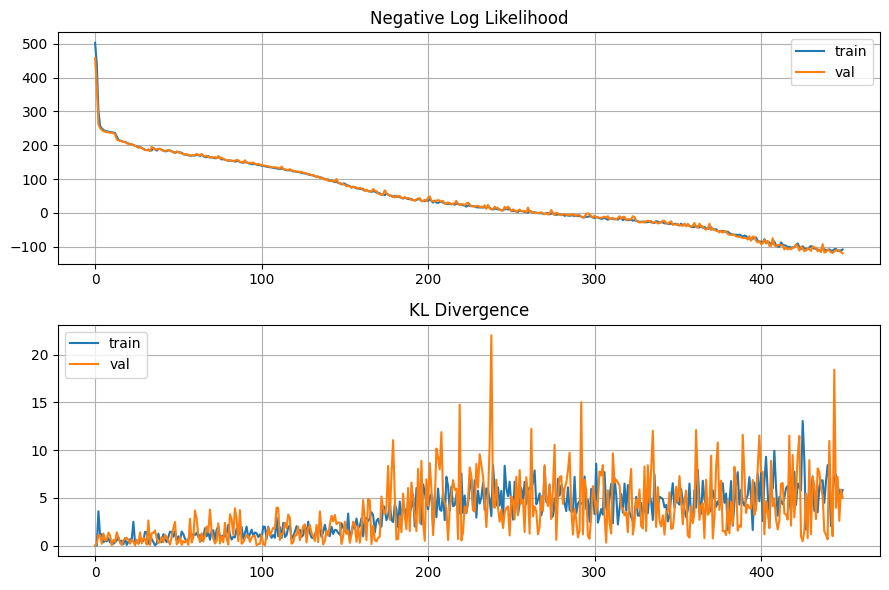

In [75]:
_, ax = plt.subplots(2, 1, figsize=(9, 6))

ax[0].plot(avg_train_neg_log_likes, label="train")
ax[0].plot(avg_val_neg_log_likes, label="val")
ax[0].set_title("Negative Log Likelihood")
ax[0].grid()
ax[0].legend()

ax[1].plot(avg_train_kl_divs, label="train")
ax[1].plot(avg_val_kl_divs, label="val")
ax[1].set_title("KL Divergence")
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

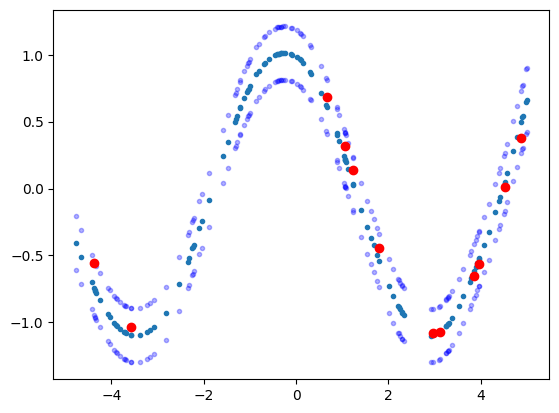

In [211]:
# model.load_state_dict(torch.load("../../models/icy-salad-8.pt"))
gen_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=True)

x_data, y_data = next(iter(gen_dataloader))
x_data, y_data = x_data.to(device), y_data.to(device)

factor = 0.1
x_context, y_context, x_target, y_target = split_context_target(x_data, y_data, factor, random=True)

n_samples = 1

model.eval()
y, y_mu, y_std = model(x_context, y_context, x_data)

for i in range(n_samples):
    plt.scatter(x_data.cpu().detach().numpy(), y_mu[i].cpu().detach().numpy(), marker=".")
    plt.scatter(
        x_data.cpu().detach().numpy(), 
        (y_mu[i] - 2 * y_std).cpu().detach().numpy(), 
        marker=".", 
        c="blue",
        alpha=0.3,
    )
    plt.scatter(
        x_data.cpu().detach().numpy(), 
        (y_mu[i] + 2 * y_std).cpu().detach().numpy(), 
        marker=".", 
        c="blue",
        alpha=0.3,
    )

plt.scatter(x_context.cpu().detach().numpy(), y_context.cpu().detach().numpy(), marker="o", c="red")

plt.show()

In [212]:
torch.save(model.state_dict(), "../../models/prime-butterfly-11.pt")

In [214]:
# model.load_state_dict(torch.load("../../models/smooth-durian-5.pt"))

from tqdm import tqdm

mus = []

num_samples = 10000

for i, (x_data, y_data) in tqdm(enumerate(gen_dataloader), total=num_samples):

    x_data, y_data = x_data.to(device), y_data.to(device)

    factor = 0.5
    x_context, y_context, _, _ = split_context_target(x_data, y_data, factor, random=False)
    r, z, z_mu, z_std = model.encode(x_data, y_data, x_data)

    mus.append(z_mu.cpu().detach().numpy())

    if i + 1 == num_samples:
        break

 41%|████      | 4096/10000 [00:25<00:36, 160.98it/s]


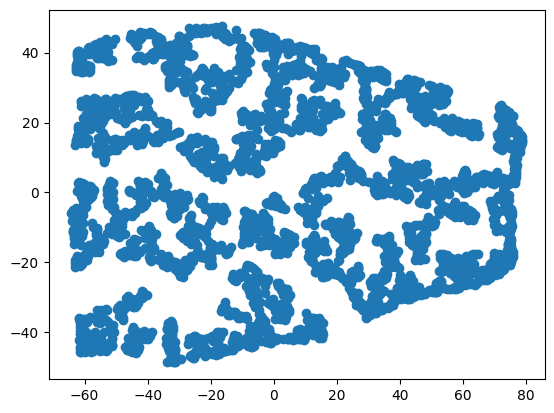

In [215]:
import numpy as np
from sklearn.manifold import TSNE

X = np.array([m[0] for m in mus])
X_embedded = TSNE(n_components=2).fit_transform(X)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.show()